# Visualization
Given our failures with the integration with kafka, we decided to play safe and save the stream to file.

Obviously this is not realtime, but we decided to follow a contingency plan and at least deliver some visualizations

## Generate the file
spark streaming creates a folder for each RDD created in the discretized stream, and a file for each partition of the rdd. To concatenate them togheter and do some claenup issue this command in the `data` folder:

`
echo "precision,recall,tp,fn,fp,tn" > results.csv && cat results_final/*/part-* | sed  's/(//g; s/)//g' >> results.csv
`



In [7]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Unbalanced classes
The following results are the product of a model trained without rebalancing the classes using subsampling.
Each line contains the state of precision, recall, and the confusion matrix, after each transaction is processed.

In [54]:
df = pd.read_csv("../data/results_nosub.csv",)

In [55]:
df.head()

,precision,recall,tp,fn,fp,tn
0,0.0,0.0,0,0,0,1
1,0.0,0.0,0,0,0,2
2,0.0,0.0,0,0,0,3
3,0.0,0.0,0,0,0,4
4,0.0,0.0,0,0,0,5


In [86]:
df.tail()

,precision,recall,tp,fn,fp,tn
28448,0.882353,0.588235,30,21,4,28394
28449,0.882353,0.588235,30,21,4,28395
28450,0.882353,0.588235,30,21,4,28396
28451,0.882353,0.588235,30,21,4,28397
28452,0.882353,0.588235,30,21,4,28398


Text(0.5,1,'Model without subsampling')

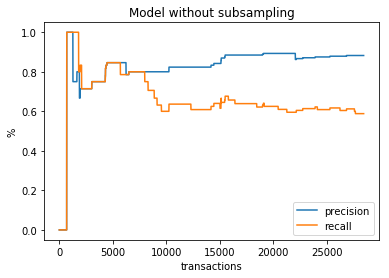

In [93]:
ax = df.plot(use_index=True, y=['precision','recall'])
ax.set_xlabel("transactions")
ax.set_ylabel("%")
ax.set_title("Model without subsampling")

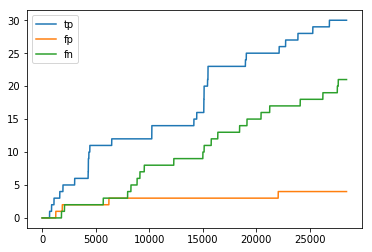

In [36]:
df.plot(use_index=True,y=['tp','fp','fn'])

As expected the number of true negative (the legit transaction) is increasing steadily given that they are the vast majority of the transactions. For this reason it is better not to consider accuracy as a performance metric as it would be very close to 100%.

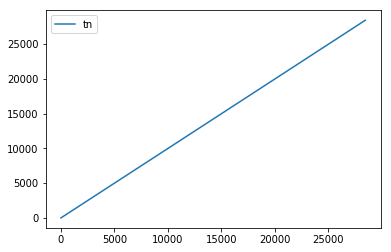

In [32]:
df.plot(use_index=True, y=['tn'])

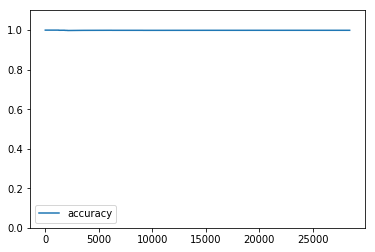

In [49]:
df['accuracy']=((df.tp + df.tn)/(df.tp+df.fp+df.tn+df.fn))
df.plot(use_index=True, y=['accuracy'],ylim=(0,1.1))

In [50]:
df.tail(1)

,precision,recall,tp,fn,fp,tn,accuracy
28452,0.882353,0.588235,30,21,4,28398,0.999121


In fact, a baseline model always guessing that a transaction is legit will achieve a 99.89 accuracy, but a precision and recall of 0 as no true positive will be identified


In [53]:
((df.tn + df.fn)/(df.tp+df.fp+df.tn+df.fn)).tail(1)

28452    0.998805
dtype: float64

# Balanced training

In [77]:
df_bal = pd.read_csv("../data/results_subsample.csv",)

In [78]:
df_bal.head()

,precision,recall,tp,fn,fp,tn
0,0.0,0.0,0,0,0,1
1,0.0,0.0,0,0,0,2
2,0.0,0.0,0,0,0,3
3,0.0,0.0,0,0,0,4
4,0.0,0.0,0,0,0,5


In [85]:
df_bal.tail()

,precision,recall,tp,fn,fp,tn
28448,0.047518,0.882353,45,6,902,27496
28449,0.047518,0.882353,45,6,902,27497
28450,0.047518,0.882353,45,6,902,27498
28451,0.047518,0.882353,45,6,902,27499
28452,0.047518,0.882353,45,6,902,27500


Text(0.5,1,'Model with subsampling')

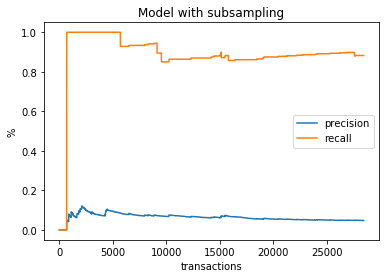

In [92]:
ax = df_bal.plot(use_index=True, y=['precision','recall'])
ax.set_xlabel("transactions")
ax.set_ylabel("%")
ax.set_title("Model with subsampling")

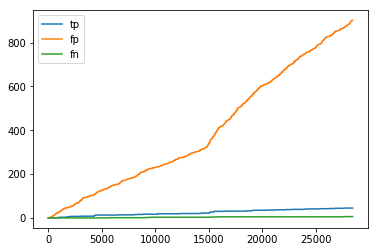

In [84]:
df_bal.plot(use_index=True,y=['tp','fp','fn'])

The final result is a recall of 88%, meaning that we are able to correctly identify roughly nine fraudolent transactions over ten. Unfortunately this comes to a high price of precision reduction. In fact a precision of 5% implies that 95 over 100 of the transactions identified as fraudolents where, in fact legit. This is clearly signaled by the high number of false positives. 

# Cost implications
The tradeoff between precision and recall can only be tuned by knowing the cost of a false negative (reinboursing the fraudolent transaction) compared to a false positive (dealing with the complaint of the user). Unfortunately we don't have this information.